In [38]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time

# Import classifiers to test
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Import metrics to analyze results
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Import functions for cross validation and parameter optimization
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [39]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
       'other', 'from_this_person_to_poi', 'director_fees',
       'deferred_income', 'long_term_incentive',
       'from_poi_to_this_person']

In [40]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [41]:
len(data_dict.keys())

146

In [42]:
for item in data_dict['METTS MARK'].keys():
    print item, data_dict['METTS MARK'][item]
print len(data_dict['METTS MARK'].keys())

salary 365788
to_messages 807
deferral_payments NaN
total_payments 1061827
exercised_stock_options NaN
bonus 600000
restricted_stock 585062
shared_receipt_with_poi 702
restricted_stock_deferred NaN
total_stock_value 585062
expenses 94299
loan_advances NaN
from_messages 29
other 1740
from_this_person_to_poi 1
poi False
director_fees NaN
deferred_income NaN
long_term_incentive NaN
email_address mark.metts@enron.com
from_poi_to_this_person 38
21


### Number of data points
Number of POI vs. Non-POI

In [57]:
print 'DATA POINTS'
print '==========='
print len(data_dict), 'total data points'
count_poi = 0
for person in data_dict:
    if data_dict[person]['poi'] == 1:
        count_poi += 1
        print person
print count_poi, 'POI;	', len(data_dict) - count_poi, 'non-POI'

DATA POINTS
143 total data points
HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F
18 POI;	125 non-POI


### Convert all 'str' and 'int' types to 'float' type

In [44]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN',np.nan)
df = df.drop('email_address', 1)

# Convert NaN to Median Value
df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# Create new features
# Fraction from poi
df['fraction_from_poi'] = df['from_poi_to_this_person']/df['from_messages']
features_list.append('fraction_from_poi')
# Fraction to poi
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
features_list.append('fraction_to_poi')

data_dict = df.T.to_dict()

### Number of Features
Split by type

In [45]:
print 'FEATURES'
print '========'
first_key = data_dict.keys()[0]
print len(data_dict[first_key].keys()), 'features total'
print
print 'Feature breakdown:'
data_types = defaultdict(list)
for key in data_dict[first_key].keys():
	data_type = type(data_dict[first_key][key])
	data_types[data_type].append(key)
print
print 'Data Types:'
for key in data_types:
	print key,':'
#	for item in data_types[key]:
#		print '   ', item
	print data_types[key]
	print '------------'

print np.isnan(data_dict['LOCKHART EUGENE E']['salary'])

FEATURES
22 features total

Feature breakdown:

Data Types:
<type 'float'> :
['to_messages', 'deferral_payments', 'expenses', 'long_term_incentive', 'from_poi_to_this_person', 'deferred_income', 'fraction_from_poi', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'director_fees', 'bonus', 'total_stock_value', 'from_this_person_to_poi', 'restricted_stock', 'salary', 'total_payments', 'fraction_to_poi', 'exercised_stock_options']
------------
<type 'bool'> :
['poi']
------------
False


### Number of NaN values

In [46]:
print 'MISSING DATA (NaN)'
print '=================='
print 'Count of NaN Values (for each feature) :'
print
# Initialize Counts:
count_nan = defaultdict(int)
for key in data_dict[first_key].keys():
	count_nan[key] = 0
# Increment Counter
for person in data_dict:
	for key in data_dict[person].keys():
		if np.isnan(data_dict[person][key]):
			count_nan[key] += 1
# Sort dictionary by value and print values
for key in sorted(count_nan, key=count_nan.get, reverse=True):
    print key, count_nan[key]

print 
print
print 'NaN by Data Point'
print '================='
count_nan_ind = defaultdict(int)
for person in data_dict:
	cnt = 0
	for key in data_dict[person].keys():
		if np.isnan(data_dict[person][key]):
			cnt += 1
	count_nan_ind[person] = cnt

for key in sorted(count_nan_ind, key = count_nan_ind.get, reverse=True)[0:14]:
	print key, count_nan_ind[key]

MISSING DATA (NaN)
Count of NaN Values (for each feature) :

to_messages 0
deferral_payments 0
expenses 0
poi 0
deferred_income 0
long_term_incentive 0
fraction_from_poi 0
restricted_stock_deferred 0
shared_receipt_with_poi 0
loan_advances 0
from_messages 0
other 0
director_fees 0
bonus 0
total_stock_value 0
from_poi_to_this_person 0
from_this_person_to_poi 0
restricted_stock 0
salary 0
total_payments 0
fraction_to_poi 0
exercised_stock_options 0


NaN by Data Point
METTS MARK 0
BAXTER JOHN C 0
ELLIOTT STEVEN 0
CORDES WILLIAM R 0
HANNON KEVIN P 0
MORDAUNT KRISTINA M 0
MEYER ROCKFORD G 0
MCMAHON JEFFREY 0
HAEDICKE MARK E 0
PIPER GREGORY F 0
HUMPHREY GENE E 0
NOLES JAMES L 0
BLACHMAN JEREMY M 0
SUNDE MARTIN 0


### Remove Outliers
'TOTAL'

'THE TRAVEL AGENCY IN THE PARK'

'LOCKHART EUGENE E'

In [47]:
outliers = ['TOTAL','THE TRAVEL AGENCY IN THE PARK','LOCKHART EUGENE E']
print 'Initial Length:', len(data_dict)
for name in outliers:
    data_dict.pop(name)
print 'Length after Outlier Removal:', len(data_dict)

Initial Length: 146
Length after Outlier Removal: 143


### Feature Selection
Use SelectKBest

In [48]:
data = featureFormat(data_dict, features_list, remove_NaN=False, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

### SelectKBest
selection = SelectKBest(k = 'all')
selection.fit(features, labels)
scores = selection.scores_
score_pairs = zip(features_list[1:], scores)
score_pairs = sorted(score_pairs, key = lambda x: x[1])
score_pairs.reverse()

top_features = ['poi']
for name, val in score_pairs:
    if len(top_features) <= 10:
        top_features.append(name)

k_best_features = dict(score_pairs[0:7], )
k_best_features

{'bonus': 15.646310196119428,
 'deferred_income': 10.183117569139776,
 'exercised_stock_options': 27.19264248325241,
 'restricted_stock': 8.3604406191721594,
 'salary': 10.806071863124094,
 'total_payments': 8.3349911967777608,
 'total_stock_value': 23.428992663609957}

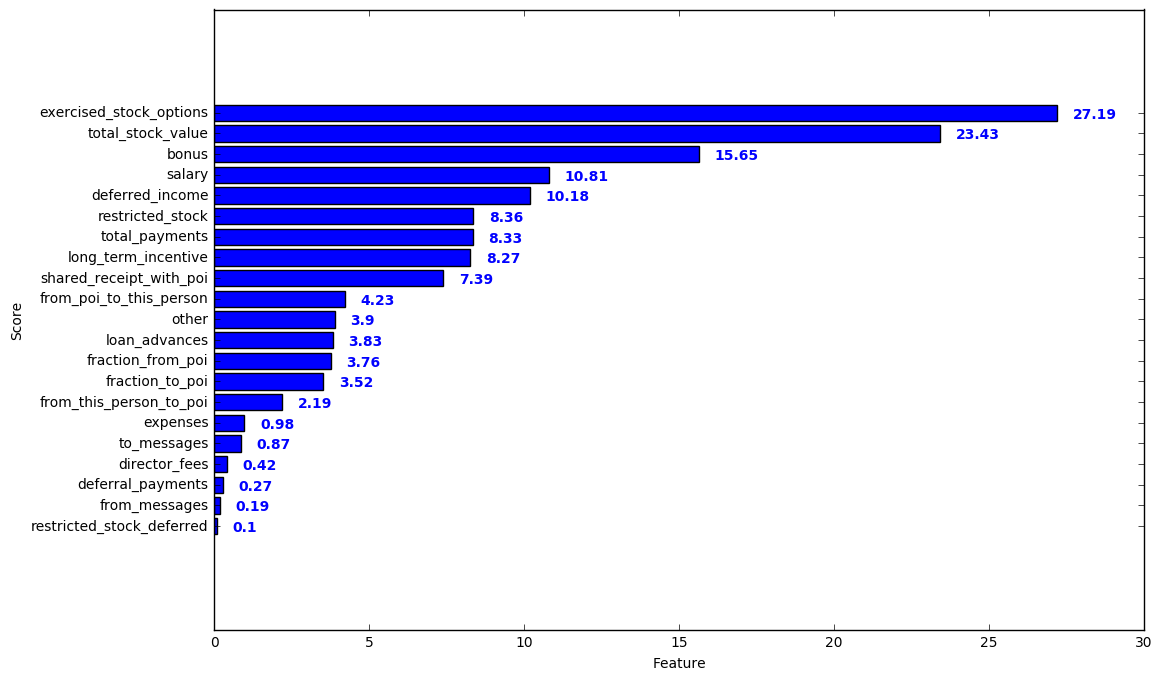

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline  
features_names = zip(*score_pairs)[0]
score = zip(*score_pairs)[1]
x_pos = np.arange(len(features_names)) 
plt.figure(figsize=(12,8))
plt.barh(x_pos, score, align='center')
plt.yticks(x_pos, features_names) 
plt.ylabel('Score')
plt.xlabel('Feature')
plt.gca().invert_yaxis()
for i, v in enumerate(score):
    v = float("{0:.2f}".format(v))
    plt.text(v + .5, i+.25, str(v), color='blue', fontweight='bold')
plt.show()




Use SelectPercentile

In [50]:
'''
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(percentile = 10)
selector.fit(features, labels)
perc_scores = selector.scores_

perc_dict = {}
for i in range(len(perc_scores)):
    perc_dict[features_list[i+1]] = perc_scores[i]

perc_dict

import operator
perc_dict = sorted(perc_dict.items(), key=operator.itemgetter(1))
perc_dict.reverse()
dict(perc_dict[0:7])
'''

'\nfrom sklearn.feature_selection import SelectPercentile\nselector = SelectPercentile(percentile = 10)\nselector.fit(features, labels)\nperc_scores = selector.scores_\n\nperc_dict = {}\nfor i in range(len(perc_scores)):\n    perc_dict[features_list[i+1]] = perc_scores[i]\n\nperc_dict\n\nimport operator\nperc_dict = sorted(perc_dict.items(), key=operator.itemgetter(1))\nperc_dict.reverse()\ndict(perc_dict[0:7])\n'

In [51]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
import operator

# Reload data using only top 10 features found through K-Best Selection
data = featureFormat(data_dict, top_features, sort_keys=True)
labels, features = targetFeatureSplit(data)
### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
model_fi = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(features, labels)

# Use model_fi to find feature importance
model_fi.fit(features, labels)
feat_imp = model_fi.feature_importances_

# summarize the selection of the attributes
#print(rfe.support_)
#print(rfe.ranking_)

ranking_dict = {}
ranking = rfe.ranking_
for i in range(len(ranking)):
    ranking_dict[top_features[i+1]] = (feat_imp[i], ranking[i])
ranking_pairs = zip(top_features[1:], feat_imp, ranking)
ranking_pairs = sorted(ranking_pairs, key = lambda x: x[1])
ranking_pairs.reverse()

ranking_dict = sorted(ranking_dict.items(), key=operator.itemgetter(1))
ranking_dict.reverse()
ranking_pairs



[('total_stock_value', 0.15818851251074678, 1),
 ('bonus', 0.14653601911166375, 2),
 ('total_payments', 0.11650441149248578, 7),
 ('exercised_stock_options', 0.11184522543553803, 1),
 ('shared_receipt_with_poi', 0.1019663371865448, 3),
 ('restricted_stock', 0.09393215937753864, 8),
 ('deferred_income', 0.087758643665491382, 1),
 ('long_term_incentive', 0.082530675173350623, 4),
 ('salary', 0.056654284767362742, 6),
 ('from_poi_to_this_person', 0.044083731279277498, 5)]

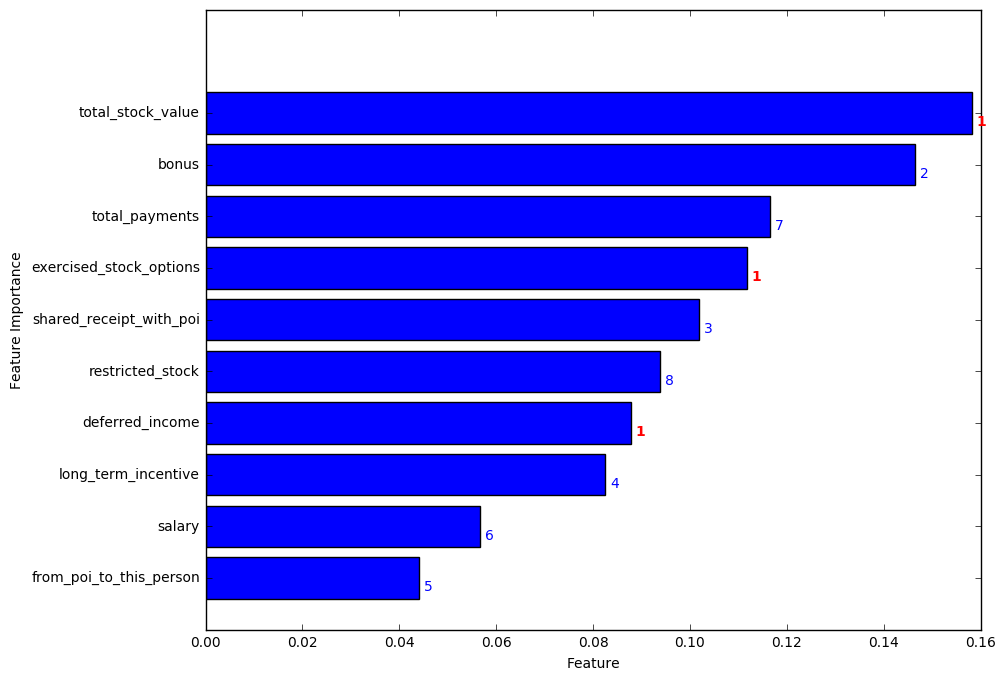

In [52]:
features_names = zip(*ranking_pairs)[0]
feature_importance = zip(*ranking_pairs)[1]
feature_ranking = zip(*ranking_pairs)[2]
x_pos = np.arange(len(features_names)) 

plt.figure(figsize=(10,8))
plt.barh(x_pos, feature_importance, align='center')
plt.yticks(x_pos, features_names) 
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.gca().invert_yaxis()
for i, v in enumerate(feature_importance):
    v = float("{0:.4f}".format(v))
    if feature_ranking[i] == 1:
        text_color = 'red'
        text_weight = 'bold'
    else:
        text_color = 'blue'
        text_weight = 'light'
    plt.text(v + .001, i+.25, str(feature_ranking[i]), color=text_color, fontweight=text_weight)
        
plt.show()

In [53]:
top_features = ['poi',
                'total_stock_value',
                'exercised_stock_options',
                'deferred_income',
                'bonus',
                'salary']
# Reload data using only top 10 features found through K-Best Selection
data = featureFormat(data_dict, top_features, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Feature scaling
from sklearn import preprocessing
features = preprocessing.MinMaxScaler().fit_transform(features)

from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(labels)

In [54]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC
clf = KNeighborsClassifier()
#X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=.3)
#clf.fit(X_train,y_train)
#y_pred = clf.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
print 'Accuracy:', np.mean(cross_val_score(clf, features, labels, scoring='accuracy', cv=cv))
print 'Recall:', np.mean(cross_val_score(clf, features, labels, scoring='recall', cv=cv))
print 'Precision:', np.mean(cross_val_score(clf, features, labels, scoring='precision', cv=cv))

#print 'Accuracy:', accuracy
#print 'Recall:', recall
#print 'Precision:', precision

Accuracy: 0.866666666667
Recall: 0.15
Precision: 0.2


In [55]:
def test_algorithm(clf, features, labels, score_str, cv):
    return np.mean(cross_val_score(clf,
                                   features,
                                   labels,
                                   scoring=score_str,
                                   cv=cv))

from sklearn.cross_validation import StratifiedShuffleSplit
import re

cv = StratifiedShuffleSplit(labels)
print StratifiedShuffleSplit()

models = [GaussianNB(), LinearSVC(), LogisticRegression(), 
          DecisionTreeClassifier(), KNeighborsClassifier(), AdaBoostClassifier(),
          RandomForestClassifier()]

test_results = {}
for i in range(len(models)):
    clf = models[i]
    clf_str = re.split(r'\(', str(clf))[0]
    test_results[clf_str] = {}
    test_results[clf_str]['Accuracy'] = test_algorithm(clf,features,labels,'accuracy',cv)
    test_results[clf_str]['Precision'] = test_algorithm(clf,features,labels,'precision',cv)
    test_results[clf_str]['Recall'] = test_algorithm(clf,features,labels,'recall',cv)

df_results = pd.DataFrame.from_dict(test_results).T


TypeError: __init__() takes at least 2 arguments (1 given)

In [ ]:
df_results

In [ ]:
ax = df_results.plot(kind='bar',figsize=(10,5),fontsize=12)
ax.set_title('Results of Different Models\n(Using Default Settings)',fontsize=16)
ax.legend(bbox_to_anchor=(0.95, 0.9, .17, 0), loc=3, ncol=1, mode='expand', borderaxespad=0)
ax.text(.12,0.265,'Score > \n      0.3',fontsize=12,color='r')
ax.set_xlabel('Algorithm',fontsize=16)
ax.set_ylabel('Score Value',fontsize=16)
ax.plot([-.5, 6.5],[0.30, 0.30],'k--',linewidth=2)
plt.show()

In [ ]:
test_classifier(RandomForestClassifier(),data_dict,top_features)

In [ ]:
from sklearn.grid_search import GridSearchCV

# Perform for RandomForestClassifier() and AdaBoostClassifier()
parameters_rfc = {'n_estimators':[2, 5, 10, 20, 40, 100], 
                  'min_samples_split':[1, 2, 3, 5], 
                  'min_samples_leaf':[1, 2, 3, 5, 10, 15]}
parameters_abc = {'n_estimators':[2, 5, 10, 15, 20, 30, 40, 50], 
                  'algorithm':('SAMME.R','SAMME'), 
                  'random_state':[10, 20, 30, 40, 50, 60]}
parameters_svr = {'loss':('squared_hinge', 'hinge'), 'C':[1, 10]}


rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
svr = LinearSVC()

clf = GridSearchCV(abc, parameters_abc)
clf.fit(features, labels)


In [ ]:
clf.best_params_

In [ ]:
test_classifier(clf.best_estimator_,data_dict,top_features)
#test_classifier(AdaBoostClassifier(),data_dict,top_features)

In [ ]:
test_classifier(GaussianNB(), data_dict, top_features)

In [59]:
import matplotlib.pyplot as plt